```
補助本「ゼロから作るDeep Learning」
3章～7章までを輪読会の補足として、読んで行きます。
Eli Kaminuma 2018.1.31
```

### 補助本6章 [2018.3.19]
# 6章　学習に関するテクニック

- 最適な重みパラメータ探索（最適化手法）
- 重みパラメータの初期値設定
- ハイパーパラメータ設定
- 過学習対策(Weight decay,Dropout)
- Batch Normalization 
  
- 目次
```
6.1 パラメータの更新
```
- 最適化（Optimization）= 損失関数の値を小さくするパラメータ探索
- SGD(Stochastic Gradient Descent:SGD)は単純な方法。SGD以外の最適化手法を紹介

In [3]:
#前準備
import numpy as np
import sys, os, time
from collections import OrderedDict # 順序付きDict
import matplotlib.pyplot as plt

sys.path.append(os.pardir) # load_mnistするために親ディレクトリを追加。必要に応じて変更 or dataset.mnistを別途import
from dataset.mnist import load_mnist

In [4]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [5]:
## これまでの章で使った関数のインポート。 
## 本来は下記の2つのインポート文でも良いが、参照しやすいように記載
# from common.layers import *
# from common.gradient import numerical_gradient

# 3.2 章
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

# 4.4章より, 微分を使った勾配算出用 
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

# 3章より
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

# 4章より
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

***

### 6.1.1 冒険家の話

- 一番深い場所を探索
- SGDは一番傾斜がきつい方向に進む戦略


***

### 6.1.2 SGD

$
w <= w - \eta \frac{\partial L}{\partial W}
$

＜勾配方法へある一定距離だけ進む＞

- w: 更新対象の重みパラメータ
- $\frac{\partial L}{\partial W}$: 損失関数の勾配
- $\eta:$学習係数、0.01や0.001等の値を事前に決める
- <= : 右辺の値で左辺の値を更新する事を表す


In [1]:
#-----------------------------------------
# \saitobook\common\optimizer.pyより
#-----------------------------------------
import numpy as np

class SGD:

    """確率的勾配降下法（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr  # lr=learning rate
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


- lr: learning rate
- params, grads : dictionary variables , (c.f. params['W1'])
- 多くのDNNフレームワークは最適化手法の切替ができる(ex.Lasagna package)
- optimizerに「パラメータ」「勾配」の情報を渡す

In [ ]:
#-----------------------------------
#実際には動かないサンプルコード（p.167）
#------------------------------
network = TwoLayerNet(...)
optimizer = SGD()
for i in range(10000):
...
x_batch, t_batch = get_mini_batch(...) # ミニバッチ
grads = network.gradient(x_batch, t_batch)
params = network.params
optimizer.update(params, grads)

### 6.1.3    SGDの欠点

- SGDは問題によっては非効率
- SGDの非効率性を考える
- 
$
f(x, y) = \frac{1}{20} x^{2} + y^{2}  (式6.2)
$
関数の最小値を求める問題を考える

- 図6-1: 式6.2のグラフと等高線
- 式6.2の等高線はx軸方向に伸びた楕円になっている
- 図6-2: 式6.2の関数の勾配図
　 - 特徴は、勾配がy軸方向で大きく、x軸方向は小さい
   - y軸方向は傾斜が急だが、x軸方向は緩やか
   - 最小値は(x,y)=(0,0)だが、勾配で多くの場所で(0,0)方向を指さない
- 図6-3: SGDによる最適化の更新経路
   - 最小値(0,0)へジグザグに動くため非効率
- SGDに代わる3つの最適化手法(Mementum, AdaGrad, Adam)   

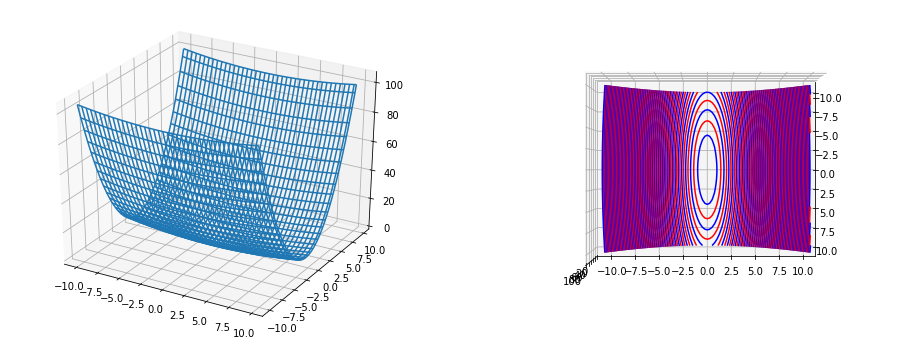

In [30]:
#------------------------------------------
# 図6.1の計算　 pp.169
#　f(x0,x1)=(1/20)x0^2+x1^2のグラフ
#--------------------------------------------

import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

def function_6_2(x):
    return (1/20)*x[0]**2 + x[1]**2

#-----graph -------------------------
x0 = np.arange(-10, 10, 0.25)
x1 = np.arange(-10, 10, 0.25)

X = np.meshgrid(x0,x1)
Z = function_6_2(X)

#-----figure--------------------------
fig = plt.figure(figsize=(16,6))

axL = fig.add_subplot(121,projection='3d')
axL.plot_wireframe(X[0],X[1],Z) 

axR = fig.add_subplot(122,projection='3d')
levels = np.arange(0, 100, 1.0)
axR.contour(X[0], X[1], Z,levels, colors=['r','b'])

axR.view_init(90, 0)

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


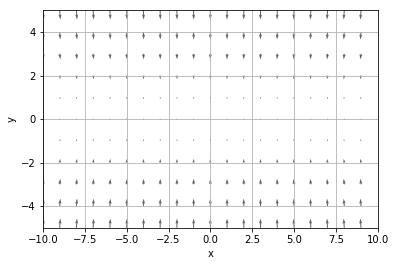

In [40]:
#-----------------------------------------
# 図6-2に式6.2の勾配図作成
#------------------------------------
#（図4.9,pp.105コードを修正)
#　
#
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D


def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def function_6_2(x):
    return (1/20)*x[0]**2 + x[1]**2

def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
if __name__ == '__main__':
    x0 = np.arange(-10, 10, 1.0)
    x1 = np.arange(-10, 10, 1.0)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()
    
    grad = numerical_gradient(function_2, np.array([X, Y]) )
    
    plt.figure()
    plt.quiver(X, Y, -grad[0]/20, -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
    plt.xlim([-10, 10])
    plt.ylim([-5, 5])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.legend()
    plt.draw()
    plt.show()

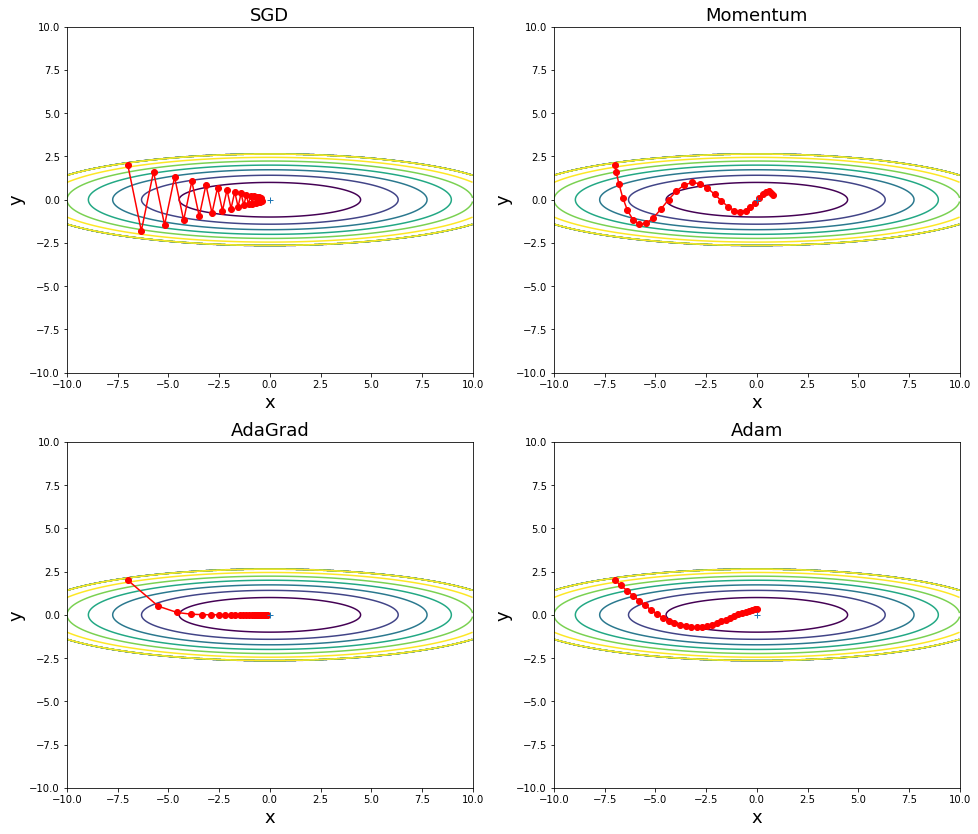

In [57]:
#------------------------------------------
# 図6.8　最適化手法の比較(SGD, Momentum, AdaGrad, Adam)
# pp.177
#-----------------------------------------
# - 多くの研究では今でもSGD
# - 最近ではAdamが良く使われている
# - ch06/optimizer_compare_naive.py
#--------------------------------------------

# coding: utf-8
import sys, os
sys.path.append('./')  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from saitobook.common.optimizer import *

#-----set functions-----------------------

def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

#-----set variables-----------------------

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

#-----load optimizers-----------------------

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

#-----figure--------------------------
fig = plt.figure(figsize=(16,14))

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key, fontsize=18)
    plt.xlabel("x", fontsize=18)
    plt.ylabel("y", fontsize=18)
    
plt.show()


4最適化手法の比較

- SGD : 勾配方向へ進むだけで非効率
  - $ w <= w - \eta \frac{\partial L}{\partial W} $

- Momentum : 勾配方向に力を受けて速度(v)が加算、ボールが地面を転がる様な動き
  - $ w <= w + v$
  - $v <= \alpha v - \eta \frac{\partial L}{\partial W} $
  - $\alpha$は、物体が何も力を受けていない時の減速項。摩擦や空気抵抗に対応。
  - $\alpha$ = 0.9に設定

- AdaGrad : 適応的に、学習係数を調整（減衰させる）
  - $ w <= w - \eta \frac{1}{\sqrt{h}}\frac{\partial L}{\partial W}$
  - $ h <= h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} $
  - hはこれまで経験した勾配の２乗和
  - パラメータ更新時に$\frac{1}{\sqrt{h}}$を乗算して学習係数を減衰する様に調整
  - 最初は大きく最小値に向かった動くが、更新度合いは弱められていく
  
- Adam
  - MomemtumとAdaGradを融合する
  - ハイパーパラメータのバイアス補正(偏り補正)が行われる
  - 3つのハイパーパラメータ設定
     - 学習係数: $\alpha$ = 0.9
     - 1次モーメント係数 $\beta_{1}$ = 0.9
     - 2時モーメント係数 $\beta_{2}$ = 0.999
  


＜AdaGradとRMSProP＞
- AdaGrad は、過去の勾配を2 乗和としてすべて記録
- 学習を進めれば進めるほど、更新度合いは小さくなる
- この問題の改善手法にRMSProp [7] 
- RMSProp手法は、過去の全勾配を均一に加算しない
- 過去の勾配を徐々に忘れて、新しい勾配情報が反映されるように加算する
- つまり指数関数的に過去勾配のスケールを減少(指数移動平均)。

＜1e-7の加算＞
- 変数値が０になった場合、1e-7 という小さい値を加算する
- 0 で除算してしまうことを防ぐ為。
- 多くのディープラーニングのフレームワークでは、小さな値も設定できる
- ここでは定値1e-7 を使用

### 6.1.8 MNISTデータセットによる更新手法の比較

- 図6-9
- ソースコード：ch06/optimizer_compare_mnist.py

===========iteration:0===========
SGD:2.379164893298908
Momentum:2.386314388826767
AdaGrad:2.3784001851300207
Adam:2.2362061019503976
===========iteration:100===========
SGD:1.4551343631461156
Momentum:0.39402053395261744
AdaGrad:0.20388401868376482
Adam:0.34051477138610314
===========iteration:200===========
SGD:0.8254462265428855
Momentum:0.3230245285433422
AdaGrad:0.15602462946377776
Adam:0.22194543516694187
===========iteration:300===========
SGD:0.5199206160866544
Momentum:0.1961426251149837
AdaGrad:0.0957992659465915
Adam:0.14266542095701532
===========iteration:400===========
SGD:0.38181987244879434
Momentum:0.17688197257610938
AdaGrad:0.06934289878713817
Adam:0.1083866095352981
===========iteration:500===========
SGD:0.4532307739991578
Momentum:0.16191359177013348
AdaGrad:0.06696352332875573
Adam:0.1061706356557223
===========iteration:600===========
SGD:0.4197758242299842
Momentum:0.12366463653975114
AdaGrad:0.043311078009109855
Adam:0.07208327606842439
===========iteration:70

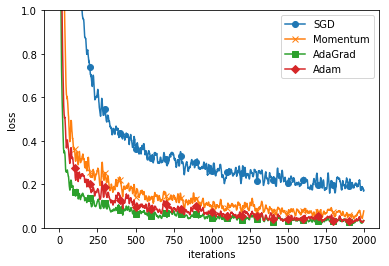

In [58]:
#------------------------------------------
# 図6.9の計算　 pp.178
#-----------------------------------------
# MNISTデータセットに対する４更新手法の比較
# - ch06/optimizer_compare_mnist.py
#--------------------------------------------

# coding: utf-8
import os
import sys
sys.path.append('../')  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from saitobook.dataset.mnist import load_mnist
from saitobook.common.util import smooth_curve
from saitobook.common.multi_layer_net import MultiLayerNet
from saitobook.common.optimizer import *


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


---

--- 

## 6.2 重みの初期値

### 6.2.1 重みの初期値を0にする？

- Weight decay（荷重減衰）
  - 過学習を抑え、汎化性能を高めるテクニック
  - 重みパラメータの値が小さくなるように学習を行う
  - 重みの値を小さくすることで、過学習が起きにくくなる
  - 重みを小さくしたければ、初期値も小さくする
- 初期値を0にすると重みが均一になり、正しい学習が行えない  

### 6.2.2 隠れ層のアクティベーション分布

- 初期値による隠れ層のアクティベーション(活性化関数の後の出力データ)の変化
  - 活性化関数の後の出力データ
  - 実験（スタンフォード大学の授業「CS231n」[5] を参考）
    - 5 層のニューラルネットワーク（活性化関数にシグモイド関数を使用）
    - ランダムに生成した入力データ
    - 各層のアクティベーションのデータ分布をヒストグラムで描画
    - ソースコードは、ch06/weight_init_activation_histogram.py




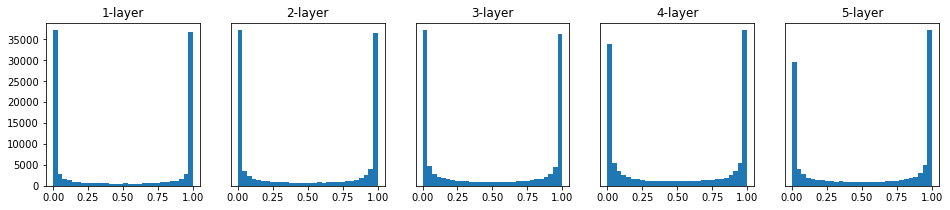

In [63]:
#--------------------------------- -------------------------------
# 図6-10:重みの初期値として「標準偏差１のガウス分布」を
# 用いたときの各層アクティベーション分布
#  - ソースコードは、ch06/weight_init_activation_histogram.py
#  - 勾配消失：0と1に偏った分布(逆伝播の勾配値が小さくなり消失する)
#  - gradient vanishing
#-------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)

    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
#-----figure--------------------------
fig = plt.figure(figsize=(16,3))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


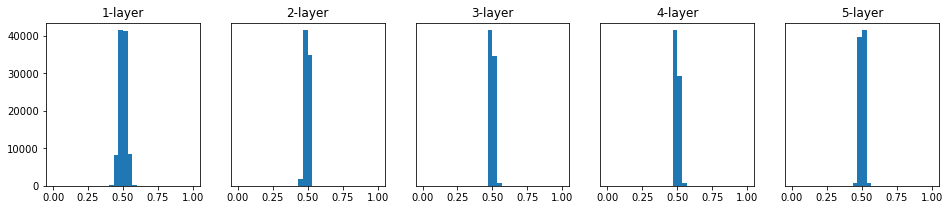

In [64]:
#--------------------------------- -------------------------------
# 図6-11:重みの初期値として「標準偏差0.01のガウス分布」を
# 用いたときの各層アクティベーション分布
#  - ソースコードは、ch06/weight_init_activation_histogram.py
#  - 0.5付近に集中する分布
#  - 勾配消失（gradient vanishing）は起きない
#  - ニューロンの一部しか使われない問題＝表現力の制限
#-------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)

    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
#-----figure--------------------------
fig = plt.figure(figsize=(16,3))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


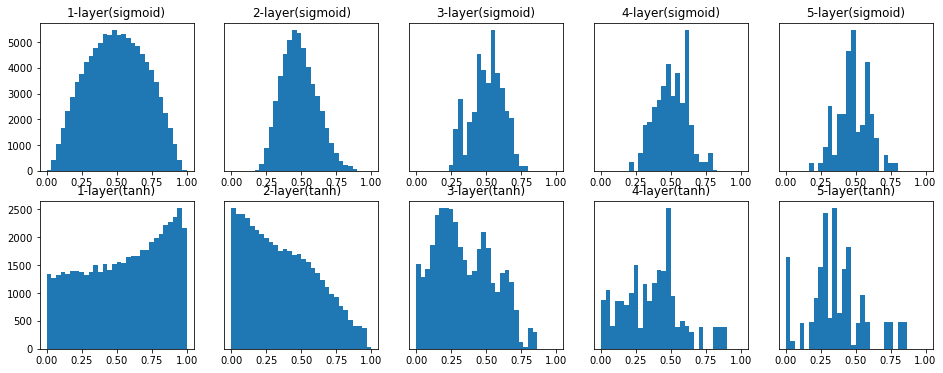

In [75]:
#--------------------------------- -------------------------------
# 図6-13:重みの初期値として「Xavierの初期値」を
# 用いたときの各層アクティベーション分布
#  - ソースコードは、ch06/weight_init_activation_histogram.py
#  - 一般的なDNNのフレームワークで標準的に用いられる（ex.caffe）
#  - 前層ノード数が多いほど初期値設置の重みスケールが小さくなる
#  - ここでは前層ノード数を１００に固定している
#  - 各層データは適度な広がり、シグモイド関数の表現力も制限されない
#  - 上位層のいびつな形はsigmoidでなくtanhを使うと改善される
#-------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
activations_tan = {}
x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num)  / np.sqrt(node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)

    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    z_tan = tanh(a)

    activations[i] = z
    activations_tan[i] = z_tan

# ヒストグラムを描画
#-----figure--------------------------
fig = plt.figure(figsize=(16,6))

for i, a in activations.items():
    #--------sigmoid--------------------------
    plt.subplot(2, len(activations), i+1)
    plt.title(str(i+1) + "-layer(sigmoid)")
    if i != 0: plt.yticks([], [])
   
    plt.hist(a.flatten(), 30, range=(0,1))

    #-----------tanh-----------------------
for i, a in activations_tan.items():
    plt.subplot(2, len(activations_tan), 5+i+1)
    plt.title(str(i+1) + "-layer(tanh)")
    if i != 0: plt.yticks([], [])
   
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


### 6.2.3 ReLUの場合の重みの初期値

- 活性化関数ReLU : Heの初期値がベストプラクティス
- 活性化関数sigmoid,tanhなどS字カーブ : Xavierの初期値がベストプラクティス


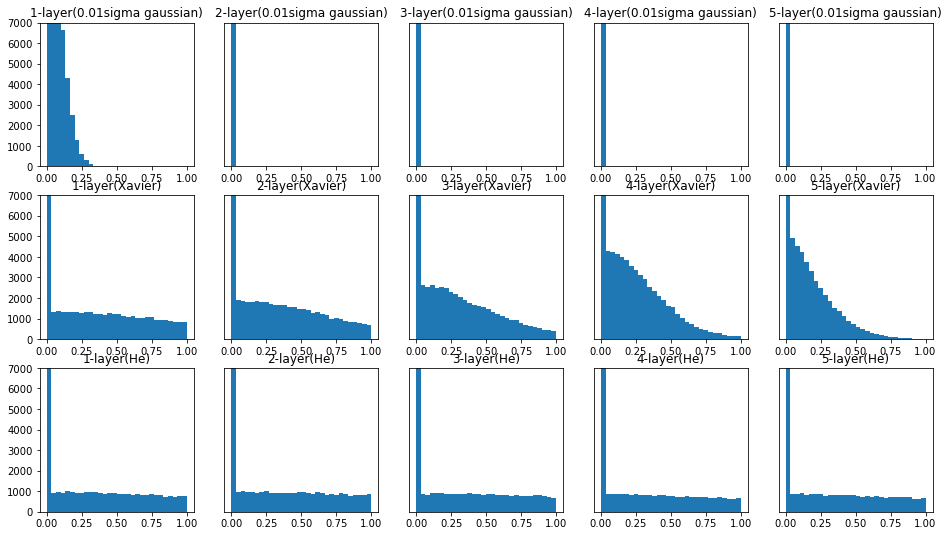

In [86]:
#--------------------------------- -------------------------------
# 図6-14　活性化関数としてReLUを使用した場合の重みの初期値による
# アクティベーション分布の変化
#　- ReLUに特化した初期値[Heの初期値]が推奨されている
#  - ソースコードは、ch06/weight_init_activation_histogram.py
#  - std=0.01のときは全く学習できておらず
#  - 前層ノード数がn個ならsqrt{1/n}を標準偏差とするガウス分布
#-------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations_1 = {}  # ここにアクティベーションの結果を格納する
activations_2 = {}
activations_3 = {}
x1 = input_data
x2 = input_data
x3 = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x1 = activations_1[i-1]
        x2 = activations_2[i-1]
        x3 = activations_3[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    # w = np.random.randn(node_num, node_num) * 1
    w1 = np.random.randn(node_num, node_num) * 0.01
    w2 = np.random.randn(node_num, node_num)  / np.sqrt(node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) 
    w3 = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) #[He初期値]


    a1 = np.dot(x1, w1)
    a2 = np.dot(x2, w2)
    a3 = np.dot(x3, w3)

    # 活性化関数の種類も変えて実験しよう！
    # z = sigmoid(a)
    z1 = ReLU(a1)
    z2 = ReLU(a2)
    z3 = ReLU(a3)
    # z_tan = tanh(a)

    activations_1[i] = z1
    activations_2[i] = z2
    activations_3[i] = z3

# ヒストグラムを描画
#-----figure--------------------------
fig = plt.figure(figsize=(16,9))

for i, a in activations_1.items():
    #--------w1--------------------------
    plt.subplot(3, len(activations_1), i+1)
    plt.title(str(i+1) + "-layer(0.01sigma gaussian)")
    if i != 0: plt.yticks([], [])
   
    plt.hist(a.flatten(), 30, range=(0,1))
    plt.ylim(0, 7000)

    #-----------w2-----------------------
for i, a in activations_2.items():
    plt.subplot(3, len(activations_2), 5+i+1)
    plt.title(str(i+1) + "-layer(Xavier)")
    if i != 0: plt.yticks([], [])
   
    plt.hist(a.flatten(), 30, range=(0,1))
    plt.ylim(0, 7000)

        #-----------w3-----------------------
for i, a in activations_3.items():
    plt.subplot(3, len(activations_3), 10+i+1)
    plt.title(str(i+1) + "-layer(He)")
    if i != 0: plt.yticks([], [])
   
    plt.hist(a.flatten(), 30, range=(0,1))
    plt.ylim(0, 7000)
plt.show()


## 6.3 Batch Normalization

- 前節の「6.2 重みの初期値」では、各層のアクティベーションの分布を観察した。
- 前節で学んだこと
   - 重みの初期値を適切に設定すれば、学習がスムーズに行える
   - 重みの初期値を適切に設定すれば、各層のアクティベーションの分布は適度な広がりを持つ
- “強制的”にアクティベーション分布を調整
   - 6.3では各層で適度な広がりを持つ様に“強制的”にアクティベーション分布を調整する
   - 実はアイデアをベースとする手法がBatch Normalization [11] 

### 6.3.1 Batch Normalizationのアルゴリズム

- Batch Normalization（以降、Batch Norm と略記）は、2015 年に提案された手法
- なぜこれほどBatch Norm が注目されているか理由

    - ● 学習を速く進行させることができる（学習係数を大きくする）
    - ● 初期値にそれほど依存しない（初期値に対して神経質にならなくてよい）
    - ● 過学習を抑制する（Dropout などの必要性を減らす）

- Batch Norm アイデア＝各層アクティベーションの分布を、適度な広がりを持つように調整する事
   - 図6-16のグレー部分のレイヤ
   - Batch Normalization レイヤ（「Batch Norm レイヤ」と表記）
   - データ分布の正規化を行う
   
-  Batch Norm は学習を行う際のミニバッチを単位とし正規化を行う
　 - データの分布が平均が0, 分散が1 になるように正規化
   - 数式で表すと次

$　

\begin{eqnarray}
μB && <=  \frac{1}{m}\Sigma_{i=1}^{m}x_{i} \\
\sigma_{B}^{2} && <= \frac{1}{m}\Sigma_{i=1}^{m}(x_{i}-\mu_{B})^{2} \\ 
\hat{x}_{i} && <= \frac{x_{i}-\mu_{B}}{\sqrt{\sigma_{B}^{2}+\epsilon}}
\end{eqnarray}

$

- Batch Norm レイヤは固有のスケールとシフトで変換を行う
   - $ yi <= \gamma \hat{x_{i}} + \beta $ (6.8)

   - $\gamma$ と$\beta$ はパラメータ
   - 最初は$\gamma = 1$, $\beta = 0$ からスタートして調整される

- Batch Normの計算グラフの図
   - 図6-17: 計算グラフにより逆伝播を簡単に計算。
   - Frederik Kratzert のブログ「Understanding the backward pass through Batch Normalization Layer」[13] に詳しい解説
 
### 6.3.2 Batch Normalizationの評価
- ソースコード:ch06/batch_norm_test.py
- 図6-18 に結果
　 - Batch Norm によって、学習が速く進む
   - さまざまな初期値のスケールを与え、学習の進行がどのように変化するか見てみましょう。
- 図6-19: 重みの初期値の標準偏差をさまざまな値に変えたときの学習経過のグラフ
   - ほとんどすべてのケースで、Batch Norm を使用したほうが学習の進みが速い
   - Batch Normを用いない場合は、良い初期値のスケールを与えないと学習が進まないことも

============== 1/16 ==============
epoch:0 | 0.116 - 0.079
epoch:1 | 0.097 - 0.097


C:\linux\github\MachineLearning_RC17\saitobook\common\layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)
C:\linux\github\MachineLearning_RC17\saitobook\common\multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\linux\github\MachineLearning_RC17\saitobook\common\multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


epoch:2 | 0.097 - 0.118
epoch:3 | 0.097 - 0.142
epoch:4 | 0.097 - 0.173
epoch:5 | 0.097 - 0.196
epoch:6 | 0.097 - 0.221
epoch:7 | 0.097 - 0.235
epoch:8 | 0.097 - 0.263
epoch:9 | 0.097 - 0.281
epoch:10 | 0.097 - 0.29
epoch:11 | 0.097 - 0.317
epoch:12 | 0.097 - 0.32
epoch:13 | 0.097 - 0.349
epoch:14 | 0.097 - 0.367
epoch:15 | 0.097 - 0.377
epoch:16 | 0.097 - 0.397
epoch:17 | 0.097 - 0.406
epoch:18 | 0.097 - 0.419
epoch:19 | 0.097 - 0.434
============== 2/16 ==============


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\linux\github\MachineLearning_RC17\saitobook\common\functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:0 | 0.117 - 0.095
epoch:1 | 0.097 - 0.11
epoch:2 | 0.097 - 0.106
epoch:3 | 0.097 - 0.116
epoch:4 | 0.097 - 0.142
epoch:5 | 0.097 - 0.16
epoch:6 | 0.097 - 0.173
epoch:7 | 0.097 - 0.198
epoch:8 | 0.097 - 0.238
epoch:9 | 0.097 - 0.251
epoch:10 | 0.097 - 0.274
epoch:11 | 0.097 - 0.297
epoch:12 | 0.097 - 0.328
epoch:13 | 0.097 - 0.344
epoch:14 | 0.097 - 0.36
epoch:15 | 0.097 - 0.389
epoch:16 | 0.097 - 0.401
epoch:17 | 0.097 - 0.419
epoch:18 | 0.097 - 0.43
epoch:19 | 0.097 - 0.454
============== 3/16 ==============
epoch:0 | 0.178 - 0.122
epoch:1 | 0.457 - 0.116
epoch:2 | 0.604 - 0.14
epoch:3 | 0.701 - 0.175
epoch:4 | 0.722 - 0.205
epoch:5 | 0.777 - 0.246
epoch:6 | 0.833 - 0.275
epoch:7 | 0.867 - 0.313
epoch:8 | 0.91 - 0.359
epoch:9 | 0.936 - 0.391
epoch:10 | 0.95 - 0.423
epoch:11 | 0.962 - 0.452
epoch:12 | 0.965 - 0.474
epoch:13 | 0.976 - 0.506
epoch:14 | 0.977 - 0.534
epoch:15 | 0.982 - 0.556
epoch:16 | 0.986 - 0.577
epoch:17 | 0.99 - 0.594
epoch:18 | 0.99 - 0.616
epoch:19 | 0.992 - 

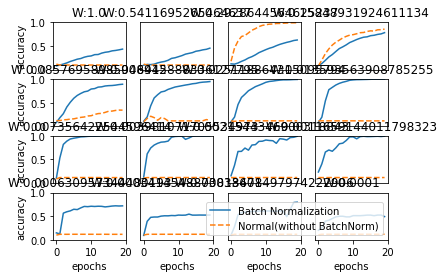

In [89]:
# coding: utf-8
import sys, os
sys.path.append('./')  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from saitobook.dataset.mnist import load_mnist
from saitobook.common.multi_layer_net_extend import MultiLayerNetExtend
from saitobook.common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()